#### Descrição do projeto:
A rede de academias Model Fitness está desenvolvendo uma estratégia de interação com o cliente baseados em dados analíticos.

Um dos problemas mais comuns que academias e outros serviços enfrentam é a rotatividade de clientes, Em vez de lutar com a rotatividade, Model Fitness digitalizou uma parte dos perfis dos clientes. Sua tarefa é analisá-los e vir com uma estratégia de retenção de clientes.
- Aprender a predizer a probabilidade de rotatividade (para o mês seguinte) para cada cliente
- Elabore retratos de usuários típicos: selecione os grupos mais marcantes e descreva suas principais características
- Analise os fatores que mais impactam a rotatividade
- Tire conclusões básicas e desenvolva recomendações sobre como melhorar o serviço de clientes:
- Identifique grupos alvo
- Sugira medidas para diminuir a rotatividade
- Descreva qualquer outro padrão que você vir com respeito às interações com clientes

In [2]:
# Importando as bibliotecas:

import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# lendo os dados:
df = pd.read_csv('/datasets/gym_churn_us.csv')
print(df.shape) # vendo o tamanho dos dados
print(df.head()) # vendo uma amostra

(4000, 14)
   gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_m

#### é possível observar que existe uma classificação binária para os dados, como '1' para 'sim', e '0' para 'não'

In [4]:
# AED

df.info()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

##### nenhum dado nulo identificado, média e desvio padrão(std) encontrados através de método describe() 

In [5]:
# realizando alguns ajustes no DF:
df.columns = df.columns.str.lower() # padronizando os nomes das colunas com str.lower() 
df = df.rename(columns={'lifetime': 'lifetime_month'}) # renomeando colunas com dados em meses (month)
print(df)

      gender  near_location  partner  promo_friends  phone  contract_period  \
0          1              1        1              1      0                6   
1          0              1        0              0      1               12   
2          0              1        1              0      1                1   
3          0              1        1              1      1               12   
4          1              1        1              1      1                1   
...      ...            ...      ...            ...    ...              ...   
3995       1              1        1              0      1               12   
3996       0              1        0              0      1                1   
3997       1              1        1              1      1               12   
3998       0              1        1              1      1                6   
3999       1              0        1              0      0               12   

      group_visits  age  avg_additional_charges_tot

In [6]:
# separando os usuários com groupby
churn = df.groupby('churn').count()
print(churn)

       gender  near_location  partner  promo_friends  phone  contract_period  \
churn                                                                          
0        2939           2939     2939           2939   2939             2939   
1        1061           1061     1061           1061   1061             1061   

       group_visits   age  avg_additional_charges_total  \
churn                                                     
0              2939  2939                          2939   
1              1061  1061                          1061   

       month_to_end_contract  lifetime_month  avg_class_frequency_total  \
churn                                                                     
0                       2939            2939                       2939   
1                       1061            1061                       1061   

       avg_class_frequency_current_month  
churn                                     
0                                   2939  
1           

#### É possível identificar que tivemos uma baixa de 1061 usuários.

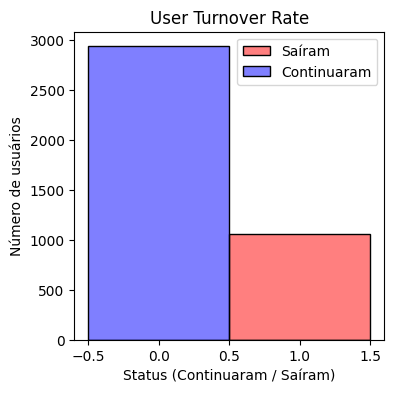

In [7]:
# Criando um histograma com os dados churn.

plt.figure(figsize=(4, 4))
sns.histplot(
    data=df,
    x='churn',
    hue='churn', 
    palette={0: 'blue', 1: 'red'},
    discrete=True)
plt.title('User Turnover Rate')
plt.xlabel('Status (Continuaram / Saíram)')
plt.ylabel('Número de usuários')
plt.legend(labels=['Saíram', 'Continuaram'])
plt.show()

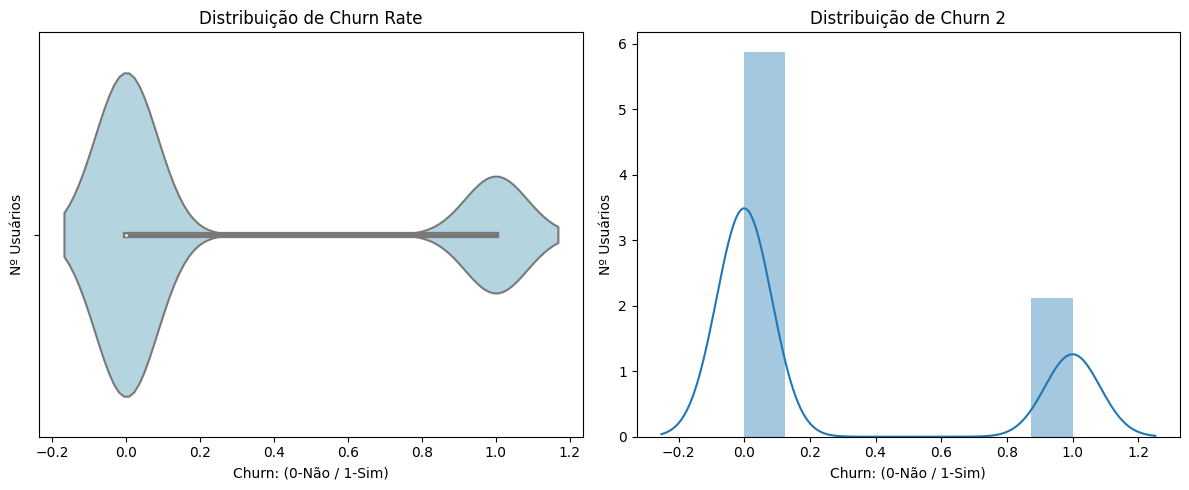

In [29]:
# Criando um grafico de violino e distribuição para verificar a distribuição dos dados para churn

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(data=df, x='churn', color='lightblue', ax=axes[0])
axes[0].set_title('Distribuição de Churn Rate')
axes[0].set_xlabel('Churn: (0-Não / 1-Sim)')
axes[0].set_ylabel('Nº Usuários')

sns.distplot(df['churn'], kde=True, ax=axes[1])
axes[1].set_title('Distribuição de Churn 2')
axes[1].set_xlabel('Churn: (0-Não / 1-Sim)')
axes[1].set_ylabel('Nº Usuários')

plt.tight_layout()
plt.show()


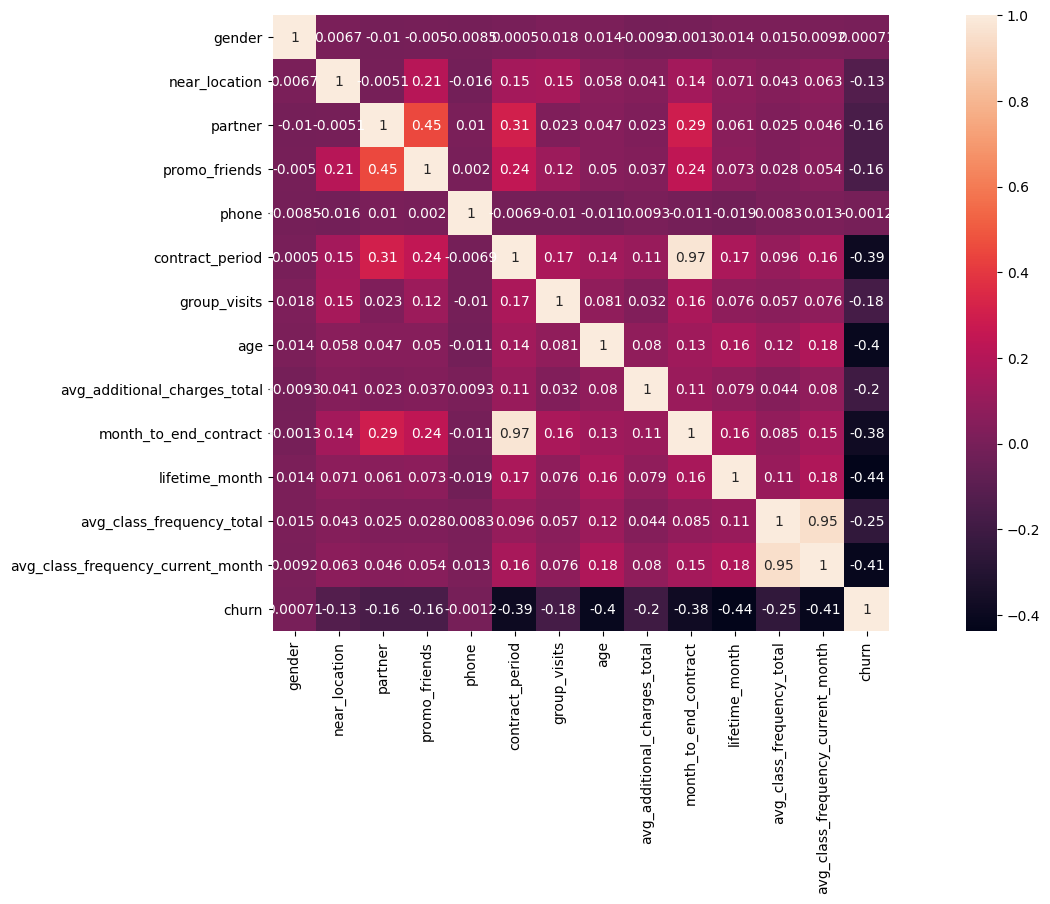

In [10]:
# Construindo uma matriz de correlação para verificar a correlação entre os dados:

cm = df.corr()

# fazendo um mapa de calor
plt.figure(figsize=(20,8))
sns.heatmap(cm, annot=True, square=True)
plt.show()

#### Resposta do aluno:
Analisando o mapa de calor, podemos observar alguns pontos importantes, fortes correlações, tanto positivas como negativas. As correlações positivas posso destacar a frequência total e  a frequência mensal que pode significar que os usuários que tem uma frequência maior na semana, tende a frequentar todo o período. 

Agora com correlações negativas, podemos ver que 'churn' se destaca em comparação com as demais características, ou seja, os clientes que cancelaram o serviço,  possuem um comportamento diferente dos demais, resultando em uma menor frequeência(por exemplo), por conseguência um menor gasto com o serviço, etc.. (o  que mostra a correlação negativa com a maioria das variáveis). Outro ponto importante a ser observado é que existe multicolinearidade em frequencia total e mensal.

### Passo 3. Construa um modelo para predizer a rotatividade de clientes
Construa um modelo de classificação binária para clientes onde a variável objetivo é a saída de usuários do próximo mês.

In [11]:
# Construindo um modelo, mas antes preciso tratar a multicolineariedade nos dados.

#### Resposta do aluno:
Levando em consideração que o estudo é de um mês, para evitar que o modelo tenha um desempenho ruim, acredito que o próximo passo é eliminar os dados da coluna 'avg_class_frequency_total', devido a sua multicolinearidade com a coluna 'avg_class_frequency_current_month' que é frequência média de visitas por semana durante o mês corrente, acredito que essa informação deve ser mantida para realizar o modelo, já que temos que prever o churn para o próximo mês, ou seja é uma infomação de vital importância para esse estudo.

In [12]:
# Eliminando a coluna 'avg_class_frequency_total' para regularização e início do estudo do modelo .

df.drop('avg_class_frequency_total', axis=1, inplace=True)

In [13]:
# Separando as variáveis, features e target ('churn').

X = df.drop(columns=['churn'])
y = df['churn']

In [14]:
# Dividindo os dados em 80/20:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [37]:
# Como estamos trabalhando com uma classificação binária, vou utilizar o modelo LogisticRegression() se necessário estarei usando o max_iter para aumentar o número de iterações para alcaçar a convergência.

#bibliotecas que ainda não foram importadas:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

# Normalização com StandardScaler
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)       

# Treinar um modelo de Machine Learning
#Regressão Logística

model = LogisticRegression()
model.fit(X_train_st, y_train)
predictions = model.predict(X_test_st)

# Verificando a Acurácia, Precisão e sensibilidade:
acc = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print("Regressão Logística:")
print(f"Acurácia: {acc:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Sensibilidade: {recall:.2f}")

# Floresta Aleatória
f_model = RandomForestClassifier(n_estimators=100, random_state=0)
f_model.fit(X_train, y_train)
f_predictions = f_model.predict(X_test)

# Verificando a Acurácia, Precisão e sensibilidade:
f_acc = accuracy_score(y_test, f_predictions)  # Calculando acurácia
f_precision = precision_score(y_test, f_predictions)
f_recall = recall_score(y_test, f_predictions)
print()
print("Floresta Aleatória:")
print(f"Acurácia: {f_acc:.2f}")
print(f"Precisão: {f_precision:.2f}")
print(f"Sensibilidade: {f_recall:.2f}")

Regressão Logística:
Acurácia: 0.90
Precisão: 0.79
Sensibilidade: 0.83

Floresta Aleatória:
Acurácia: 0.90
Precisão: 0.81
Sensibilidade: 0.76


#### Resposta do aluno: Como podemos ver acima, ambos os métodos tem 90% de acurácia, e praticamente a mesma precisão, visto que a diferença é de 2%, contudo a Regressão Logística tem uma sensibilidade melhor, o que significa que ela está identificando um maior número de verdadeiros positivos, será mais eficaz em identificar as ocorrências da classe positiva (por exemplo, clientes que irão sair 'churn') que é o nosso objetivo principal.

### Passo 4. Crie agrupamentos de clientes
Defina ao lado colunas com dados sobre rotatividade e identifique agrupamentos do objeto (cliente):

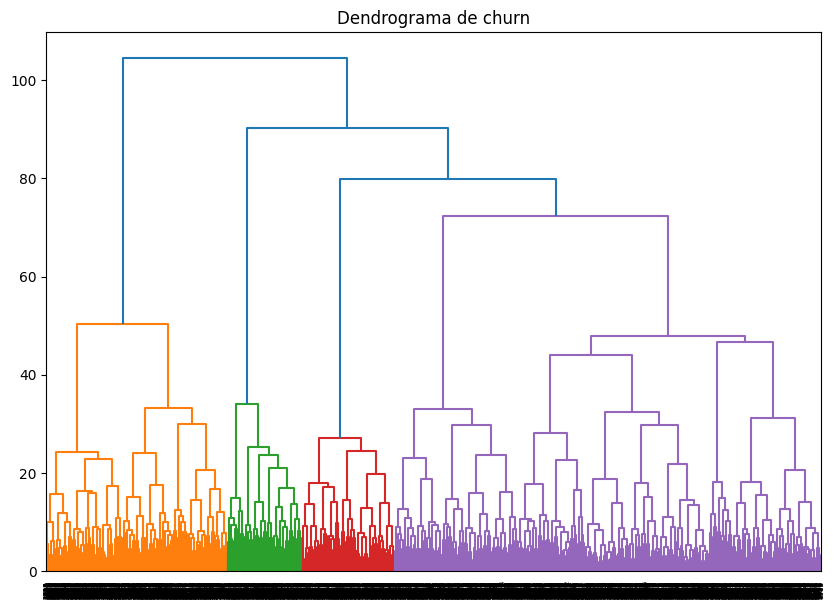

In [18]:
# o proximo passo para essa nova etapa é separar as colunas que são importantes para estudar o churn, e padronizar os dados.

#importando biblioteca que não foi importada anteirormente para fazer o dendograma.
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch

# selecionando as colunas conforme solicitado para a análise de rotatividade e identificar agrupamentos.

# Seleção das colunas
columns_of_interest = [
    'churn', 'gender', 'near_location', 'partner', 'promo_friends', 'phone', 
    'age', 'lifetime_month', 'contract_period', 'month_to_end_contract', 'group_visits', 
    'avg_class_frequency_current_month', 'avg_additional_charges_total'
]

# Filtrando o DataFrame
df = df[columns_of_interest]

# Convertendo colunas categóricas para variáveis dummy
df = pd.get_dummies(df, drop_first=True)

# Variável dependente (o target que o modelo irá prever) e independentes (features que influenciam o target)
y = df['churn']
X = df.drop(columns=['churn'])

# Padronizando os dados
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Construindo a matriz de distâncias usando a linkage:
lk = sch.linkage(X_sc, method='ward')

#dendograma usando o likage:
plt.figure(figsize=(10, 7))
sch.dendrogram(lk, orientation='top')
plt.title('Dendrograma de churn')
plt.show()


In [19]:
#Treinando o modelo de agrupamento com o algoritmo K-means
kmeans = KMeans(n_clusters=5)# definindo o número de agrupamentos como 5
kmeans.fit(X_sc)

# Prevendo os agrupamentos para os dados
y_kmeans = kmeans.predict(X_sc)

# Adicionando o número do cluster ao DataFrame original
df['cluster'] = y_kmeans

# Calculando a taxa de rotatividade por agrupamento
churn_rate = df.groupby('cluster')['churn'].mean()
print(churn_rate)

cluster
0    0.618470
1    0.028259
2    0.266839
3    0.426667
4    0.043478
Name: churn, dtype: float64


#### Resposta do aluno: Foi calculado a taxa de rotatividade para cada grupo, utilizando o groupby(), podemos observar que o agrupamento 3 tem a maior taxa de rotatividade.

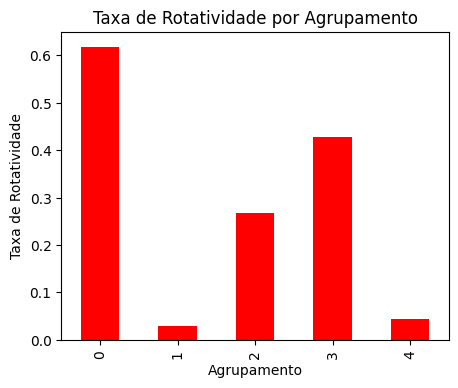

In [20]:
# Verificando a distribuição da taxa de rotatividade 'churn' para cada grupo
churn_rate.plot(kind='bar', figsize=(5, 4), color='red')
plt.title('Taxa de Rotatividade por Agrupamento')
plt.xlabel('Agrupamento')
plt.ylabel('Taxa de Rotatividade')
plt.show()

#### agrupamentos 3 tem a maior taxa de rotatividade.

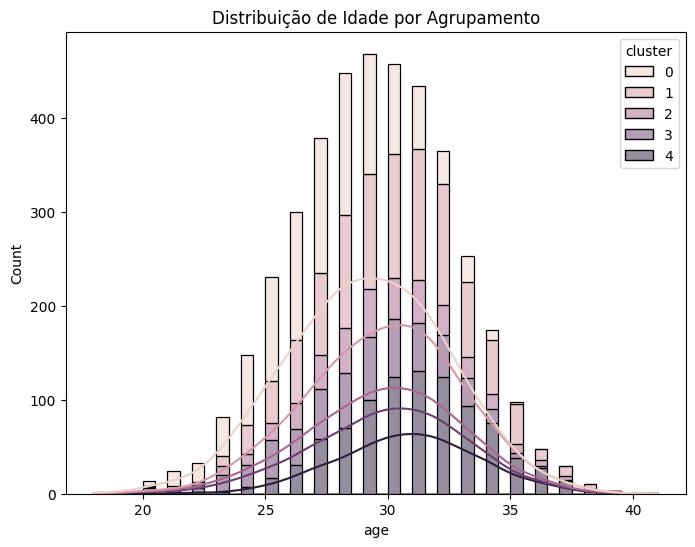

In [21]:
# Verificando a distribuição para a característica IDADE para cada agrupamento.
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='age', hue='cluster', kde=True, multiple='stack')
plt.title('Distribuição de Idade por Agrupamento')
plt.show()

#### Podemos observar que os grupos 0 e 3 tem a maior taxa de rotatividade 'churn', nesses grupos a grande maioria dos usuários estão entre 25 e 32 anos.

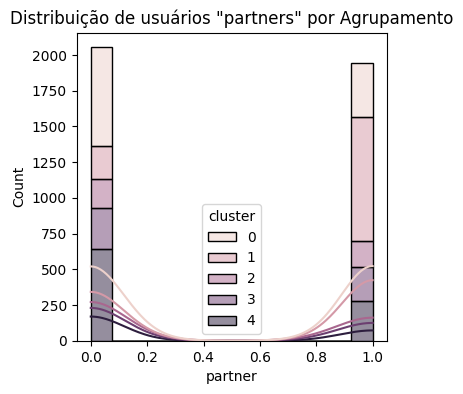

In [22]:
# Verificando a distribuição para a característica 'usuários que são funcionários de parceiros' para cada agrupamento.
plt.figure(figsize=(4, 4))
sns.histplot(data=df, x='partner', hue='cluster', kde=True, multiple='stack')
plt.title('Distribuição de usuários "partners" por Agrupamento')
plt.show()

#### Podemos observar que no grupo 3 (onde taxa de rotatividade é maior), os usuários que são 'partners' representam uma parcela muito pequena em comparação aos demais. já os usuários que não se encaixam nessa categoria, representam uma grande quantidade neste grupo, sendo predominante entre esses usuários.

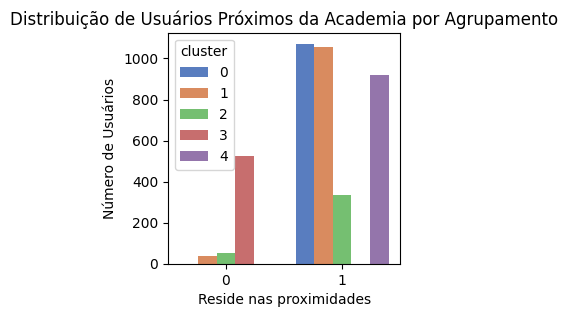

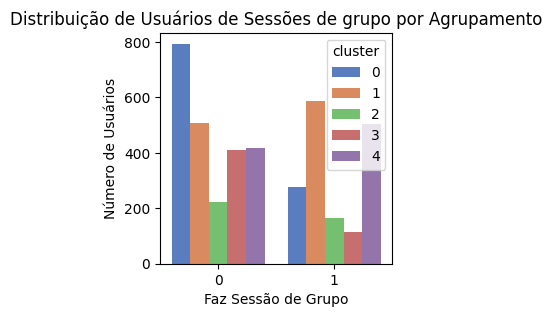

In [23]:
# verificando os clientes que moram proximos a academia:

plt.figure(figsize=(3, 3))
sns.countplot(data=df, x='near_location', hue='cluster', palette='muted')
plt.title('Distribuição de Usuários Próximos da Academia por Agrupamento')
plt.xlabel('Reside nas proximidades')
plt.ylabel('Número de Usuários')
plt.show()

# verificando os clientes que participam de sessões de grupo na academia:
plt.figure(figsize=(3, 3))
sns.countplot(data=df, x='group_visits', hue='cluster', palette='muted')
plt.title('Distribuição de Usuários de Sessões de grupo por Agrupamento')
plt.xlabel('Faz Sessão de Grupo')
plt.ylabel('Número de Usuários')
plt.show()

#### Passo 5. Chegando à conclusões e fazendo recomendações básicas sobre como trabalhar com clientes

#### Resposta do aluno: Foi possível obter algumas informações com a AED, e com o mapa de calor, onde podemos observar a discrepência dos dados dos usuários com churn over, mostrando uma diferença significativa no comportamento em relação aos demais usuários, o que é o nosso objetivo para a análise, e com a ajuda dos testes, obtemos mais informações a respeito, foram realizados os testes conforme os parâmetros solicitados, e antes de aplicar foi conferido e comparado a acurária, precisão e sensibilidade dos mesmos, e após esse procedimento os testes foram realizados, foi realizado um agrupamento, onde os grupos que se mostraram com alta taxa de rotatividade (previsão) foram os grupos 0 e 3, e conseguimos obter informações sobre os usuários desses grupos, podemos observar que são usuários entre 25 e 32 anos, que não são funcionários de parceiros, e que  não participam de sessões de grupo. Outro detalhe importante observado na preparação dos dados para o teste, foi que usuários que tiveram uma frequência alta durante a semana, provavelmente terá frequência no restante do período. 
#### O que podemos deixar para a equipe de marketing como sugestão é estudar o perfil do usuário que entra nessas caraterísticas, para desenvolver uma campanha, que motive a frequência do mesmo já nas primeiras semanas, ingressa-lo nas sessões de grupos,  e ofereça pacotes para mais parceiros, isso ai irá aumentar a taxa de retenção de clientes na academia.